In [57]:
import os
import time
import numpy as np
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import copy
import datetime
import traceback
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

In [58]:
import pandas as pd

In [59]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

## Часть 1

#### Задание 1.1 [6 баллов]

Реализуйте свой класс LogReg - собственная имплементация логистической регрессии с l2 регуляризацией

In [60]:
from sklearn.base import BaseEstimator

In [96]:
class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, gd_type='full', batch_size=None,
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, 
                 verbose=False, alpha_shrinkage_factor=0.1):
        """
        lambda_2: L2 regularization param value
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.batch_size = None if self.gd_type == 'full' else batch_size
        if self.batch_size is None and self.gd_type != 'full':
            raise Exception('Need to specify batch size!')
        self.w0 = w0
        self.alpha = alpha
        self.alpha_shrinkage_factor = alpha_shrinkage_factor
        self.w = None
        self.loss_history = []
        self.w_history = []
        self.grad_norm_history = []
        self.verbose = verbose
        # Могут быть ешё параметры
        
    def sigmoid(self, z):
        """
        Просто вычисляет сигмоиду
        """
        # Ваш код здесь:
        
        return 1/(1 + np.exp(-z))
    
    
    def fit(self, X, y):
        """
        X: np.array of shape (N, d)
        y: np.array of shape (N, 1)
        """
        # Ваш код здесь:
        
        if self.w is None:
            self.w = self.w0 if self.w0 is not None else np.random.randn(X.shape[1], 1)
       
        loss = self.calc_loss(X, y)
        grad = self.calc_gradient(X, y)
        self.loss_history = [loss + 100, loss]
        self.w_history = [self.w.ravel()]
        self.grad_norm_history = [np.linalg.norm(grad)]
        iteration = 1
        while iteration < self.max_iter and \
            abs(self.grad_norm_history[-1]) > self.tolerance:
            start_time = time.perf_counter()
            if self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
            else:
                batch_indexes = np.random.choice(np.arange(X.shape[0]),
                                                 replace=False, size=self.batch_size)
                gradient = self.calc_gradient(X[batch_indexes], y[batch_indexes])
            if iteration > 5:
                if np.std(self.grad_norm_history[-5:]) < 1e-4:
                    self.alpha = self.alpha*self.alpha_shrinkage_factor
           
            self.w = self.w - self.alpha*gradient
            loss = self.calc_loss(X, y)
            if self.verbose:
                print('Iteration: {} Loss: {:.4f} Time: {}'.format(iteration, loss,
                                                    time.perf_counter() - start_time))
           
            self.grad_norm_history.append(np.linalg.norm(gradient))
            self.w_history.append(self.w.ravel())
            self.loss_history.append(loss)
            iteration += 1
           
        if iteration < self.max_iter:
            print('Target accuracy chieved!')
           
        self.loss_history = self.loss_history[1:]
       
        return self
    
    
    def predict_proba(self, X):
        """
        X: np.array of shape (N, d)
        ---
        output: np.array of shape (N, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        # Ваш код здесь:
        
        if self.w is None:
            raise Exception('Not trained yet')
       
        return self.sigmoid(X.dot(self.w))
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (N, d) (N is equal to batch_size if gd_type="stochastic")
        y: np.array of shape (N, 1)
        ---
        output: np.array of shape (d, 1)
        """
        # Ваш код здесь:
        
        if self.w is None:
            self.w = self.w0 if self.w0 is not None else np.random.randn(X.shape[1], 1)
           
        grad_logloss = (-(1/X.shape[0])*y*X*self.sigmoid(-y*X.dot(self.w))).sum(axis=0)\
                        .reshape(-1, 1) + self.lambda_2*self.w
        return grad_logloss
        

    def calc_loss(self, X, y):
        """
        X: np.array of shape (N, d)
        y: np.array of shape (N, 1)
        ---
        output: float 
        """ 
        # Ваш код здесь:
        
        if self.w is None:
            self.w = self.w0 if self.w0 is not None else np.random.randn(X.shape[1], 1)
                                                                         
        loss = (1/X.shape[0])*np.log(1 + np.exp(-y*X.dot(self.w))).sum() + \
               (self.lambda_2/2)*np.linalg.norm(self.w)**2
        return loss
        

Сгенерируем модельную выборку, для проверки нашего класса

In [97]:
N = 100000
X = np.random.normal(loc=0, scale=4, size=(N))
X = np.hstack((
    np.ones(X.shape[0]).reshape(-1, 1),
    X.reshape(-1, 1)
))
y = (
    2*(3*X[:, 1] + np.random.normal(scale=4, size=N) > 0) - 1
).astype(int).reshape(-1, 1)
w_init = np.random.randint(-10, 10, size=(2, 1))

Разделите данные на обучение и контроль

In [98]:
# Ваш код здесь:
train_split = int(len(y) * 0.7)
y_train = y[:train_split]
y_test = y[train_split:]
X_train = X[:train_split]
X_test = X[train_split:]
print("Обучающая выборка X:", len(X_train))
print("Тестовая выборка X:", len(X_test))
print("Обучающая выборка y:", len(y_train))
print("Тестовая выборка y:", len(y_test))
print()

Обучающая выборка X: 70000
Тестовая выборка X: 30000
Обучающая выборка y: 70000
Тестовая выборка y: 30000



#### Задание 1.2 [3 балла]

Обучите Вашу реализацию логрега на обучающей выборке и протестируйте качество на котрольной выборке. Нарисуйте графики лосса в зависимости от числа итераций для обучения для полного градиентного спуска, а так же для стохастического градиентного спуска c различной величиной батча (батч размера 1, 10, 20, 30, половина выборки, вся выборка) 

In [99]:
# Ваш код здесь:
logistic_regression= LogReg()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict_proba(X_test)

In [100]:
y_pred 

array([[0.56063123],
       [0.22427151],
       [0.45605081],
       ...,
       [0.09798482],
       [0.92054732],
       [0.77923867]])

In [101]:
y_test

array([[ 1],
       [-1],
       [ 1],
       ...,
       [-1],
       [ 1],
       [ 1]])

In [102]:
for i in range (0, len(y_pred)):
    if y_pred[i] <= 0.5:
        y_pred[i] = -1
    else: 
        y_pred[i] = 1

In [103]:
y_pred

array([[ 1.],
       [-1.],
       [-1.],
       ...,
       [-1.],
       [ 1.],
       [ 1.]])

 # точность

In [104]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8948333333333334


In [105]:
# Определим наилучшие параметры модели
iters = range(0, 10001, 500)
batches = (1, 10, 20, 30, len(y_train)//2)
gd_types = ('full', 'stochastic')
losses = pd.DataFrame()

In [107]:
loss_full = []
iters = [*range(0, 10001, 500)]
batches = [1, 10, 20, 30, len(y_train)//2, len(y_train)]
for i in tqdm_notebook(iters):
    temp_list = []
    for b in batches:
        lr = LogReg(gd_type='full', batch_size=b, max_iter=i)
        lr.fit(X_train, y_train)
        temp_list.append(lr.calc_loss(X_test, y_test))
    loss_full.append(temp_list)

In [108]:
loss_for_full = pd.DataFrame(loss_full, index = iters, columns = batches)

In [109]:
loss_stoch = []
iters = [*range(0, 10001, 500)]
batches = [1, 10, 20, 30, len(y_train)//2]
for i in tqdm_notebook(iters):
    temp_list = []
    for b in batches:
        lr = LogReg(gd_type='stochastic', batch_size=b, max_iter=i)
        lr.fit(X_train, y_train)
        temp_list.append(lr.calc_loss(X_test, y_test))
    loss_stoch.append(temp_list)

Target accuracy chieved!
Target accuracy chieved!
Target accuracy chieved!
Target accuracy chieved!
Target accuracy chieved!
Target accuracy chieved!


In [110]:
loss_for_stoch = pd.DataFrame(loss_stoch, index = iters, columns = batches)

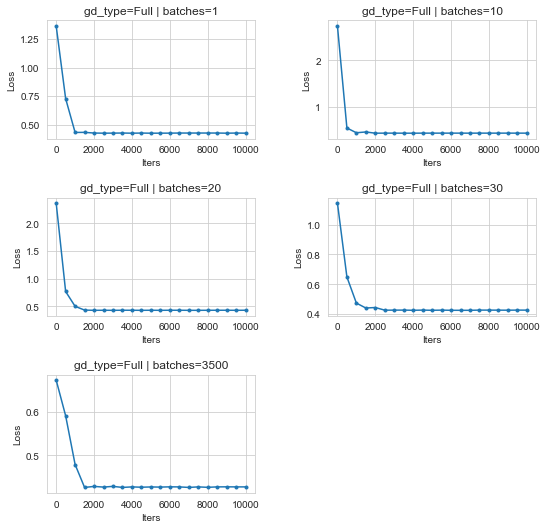

In [111]:
# Строим графики для Full

fig = plt.figure()

plt.subplot(3, 2, 1)
plt.plot(iters, loss_for_full.iloc[:, 0], '.-')
plt.title('gd_type=Full | batches=1')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplot(3, 2, 2)
plt.plot(iters, loss_for_full.iloc[:, 1], '.-')
plt.title('gd_type=Full | batches=10')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplot(3, 2, 3)
plt.plot(iters, loss_for_full.iloc[:, 2], '.-')
plt.title('gd_type=Full | batches=20')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplot(3, 2, 4)
plt.plot(iters, loss_for_full.iloc[:, 3], '.-')
plt.title('gd_type=Full | batches=30')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplot(3, 2, 5)
plt.plot(iters, loss_for_full.iloc[:, 4], '.-')
plt.title('gd_type=Full | batches=3500')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplots_adjust(top=0.92, bottom=0.1, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)

plt.show()

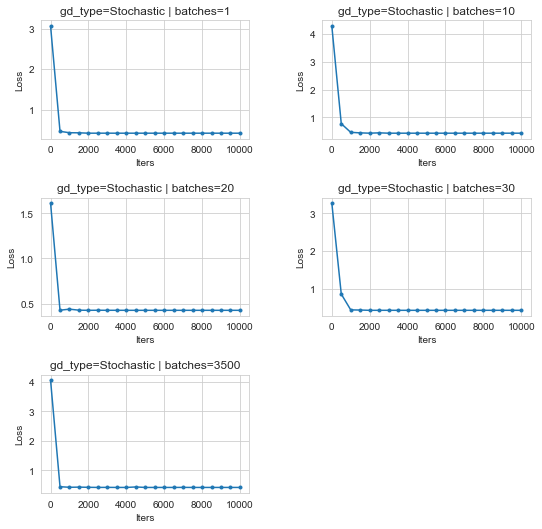

In [112]:
# Строим графики для Stochastic

fig = plt.figure()

plt.subplot(3, 2, 1)
plt.plot(iters, loss_for_stoch.iloc[:, 0], '.-')
plt.title('gd_type=Stochastic | batches=1')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplot(3, 2, 2)
plt.plot(iters, loss_for_stoch.iloc[:, 1], '.-')
plt.title('gd_type=Stochastic | batches=10')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplot(3, 2, 3)
plt.plot(iters, loss_for_stoch.iloc[:, 2], '.-')
plt.title('gd_type=Stochastic | batches=20')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplot(3, 2, 4)
plt.plot(iters, loss_for_stoch.iloc[:, 3], '.-')
plt.title('gd_type=Stochastic | batches=30')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplot(3, 2, 5)
plt.plot(iters, loss_for_stoch.iloc[:, 4], '.-')
plt.title('gd_type=Stochastic | batches=3500')
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.subplots_adjust(top=0.92, bottom=0.1, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)

plt.show()

## Часть 2
## Word2Vec

В этой части задания Вам необходимо будет реализовать алгоритм поиска эмбеддингов для слов Word2Vec (модификация SkipGramNS)

Загрузите лемматизированные тексты lemm_wiki_texts.txt для обучения

In [23]:
# Загрузка текстов
with open('/Users/anastasiatolstun/Desktop/lemm_wiki_texts.txt', mode='r', encoding='utf-8') as f:
    lemm_wiki_texts = f.readlines()

In [21]:
# у вас должно получиться 1095910 текстов - проверьте
# Ваш код здесь:
len(lemm_wiki_texts)

1095910

In [22]:
print(lemm_wiki_texts[:10])

['литва официальный название лить вскай респу блик государство расположить северный часть европа столица страна вильнюс площадь км² протяжённость север на юг километр запад на восток километр население составлять человек сентябрь иметь выход балтийский море расположить на он восточный побережье береговой линия составлять всего километр наименьший показатель среди государство балтия на север граничить латвия на юго восток белоруссия на юго запад польша калининградский область россия член оон год ес нато год оэср май год входить шенгенский зона еврозона независимость страна провозгласить март год юридически оформить сентябрь год этимология этимология слово литва точно не известный при это существовать множество версия ни один из который не получить всеобщий признание корень лита он вариант год лютый допускать различный толкование как балтский славянский так другой индоевропейский язык так например существовать созвучный топоним на территория словакия lytva румыния litua известный xi xii 

#### Задание 2.0 [1 балл]

Реализуйте функцию, которая принимает на вход список текстов (такой например, как lemm_wiki_texts) и выдаёт список списков, где каждый внутренний список содержит 3 элемента: 2 слов и 1 число (0 или 1), символизирующее, находится ли пара слов в одном контексте, или нет.

In [6]:
def prepare_text_for_skipgramns(texts: list, context_width: int=5, negative_samples: int=10) -> list:
    resulting_list =[]
    for i in range(0, len(texts)+1):
        wi = texts[i]
        window_start = max(0, i - context_width)
        window_end = min(len(texts), i + context_width + 1)
        for j in range(window_start, window_end):
            if j != i:
                wj = texts[j] 
        resulting_list.append([wi, wj, 1])    
    """
    texts: список текстов, по которому необходимо будет составить итоговый список
    context_width: ширина окна. Слова, находящиеся в одном окне считаются из одного контекста
    negative_samples: сколько негативных примеров генерировать на каждый положительный пример.
    return: resulting_list: Пример: [
    ["мама", "готовит", 1],
    ['мама', "океан", 0],
    ["надёжный", "подрядчик", 1],
    ["надёжный", "мороженое", 0],
    ...
    ]
    """
    # Ваш код здесь:
    return resulting_list

In [52]:
prepare_text_for_skipgramns(lemm_wiki_texts, 5, 10)

IndexError: list index out of range

#### Задание 2.1 [15 баллов]

Реализуйте класс, который будет использоваться для обучения Word2Vec векторов. Реализовывать можно как на голом numpy, так и с помощью вспомогательных библиотек. Рекомендуется освоить библиотеку, [pytorch](https://pytorch.org/). Во-первых, она будет в дальнейшем использоваться, при прохождении нейросетей, а во-вторых, есть видео, которое шаг за шагом позволяет реализовать Word2Vec алгоритм на pytorch:
https://stepik.org/lesson/247966/step/1?unit=220078 (P.S. Можно просто реализовать Word2Vec точно так же, как на видео)

У этого класса обязательно должен быть метод, который "обучает" эмбеддинги. Результатом обучения должен быть словарь (dict), ключами которого являются слова, а значениями - эмбеддинги этих слов

In [4]:
!conda install pytorch torchvision -c pytorch --yes

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::numpy==1.15.1=py37h6a91979_0
  - defaults/osx-64::dask==0.19.1=py37_0
  - defaults/osx-64::mkl_fft==1.0.4=py37h5d10147_1
  - defaults/osx-64::scikit-learn==0.19.2=py37h4f467ca_0
  - defaults/osx-64::bottleneck==1.2.1=py37h1d22016_1
  - defaults/osx-64::h5py==2.8.0=py37h878fce3_3
  - defaults/osx-64::statsmodels==0.9.0=py37h1d22016_0
  - defaults/osx-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/osx-64::scipy==1.1.0=py37h28f7352_1
  - defaults/osx-64::matplotlib==2.2.3=py37h54f8f79_0
  - defaults/osx-64::bkcharts==0.2=py37_0
  - defaults/osx-64::pywavelets==1.0.0=py37h1d22016_0
  - defaults/osx-64::patsy==0.5.0=py37_0
  - defaults/osx-64::imageio==2.4.1=py37_0
  - defaults/osx-64::mkl_random==1.0.1=py37h5d10147_1
  - defaults/osx-64::numpy-base==1.15.1=py37h8a80b8c_0
  - defaults/osx-64::anaconda==5.3.1=py37_

In [179]:
import sys; sys.path.append('stepik-dl-nlp')

In [180]:
import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

In [29]:
random.shuffle(lemm_wiki_texts)
TRAIN_VAL_SPLIT = int(len(lemm_wiki_texts) * 0.7)
train_source = lemm_wiki_texts[:TRAIN_VAL_SPLIT]
test_source = lemm_wiki_texts[TRAIN_VAL_SPLIT:]

In [24]:
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 767137
Тестовая выборка 328773

музыкальный архив вернер икинг wima веб архив свободно лицензионный партитура являться общественный достояние назвать честь он основатель покойный вернер икинг множество файл набрать доброволец электронный вид формат pdf wima продолжать дело ныне не существующий gmd music archive после слияние завершиться год архив являться частью international music score library project imslp история математик вернер икинг июнь февраль год погибнуть велосипедный авария возвращаться домой работа провести большой часть свой карьера gesellschaft für mathematik und национальный центр прикладной математика информатика санкт августин германия gmd поздний войти состав общество фраунгофер он не только сыграть важный роль развитие распространение программный обеспечение musixtex но также разработать новое издание музыка композитор эпоха барокко особенно полный уртекст издание произведение бах для соло скрипка виолончель течение некоторый время вернер быть один

In [30]:
#токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

осся освальд февраль январь уродить освальд штеглихо oswalda stäglich немецкий актриса немой кино биография освальд родиться февраль пригород берлин нидершёнхаузный семья гимназический учитель детство заниматься балет затем танцевать берлинский театр дебютировать кино фильм рихард освальд ужас ночь затем журналист ганс красть порекомендовать начинающий актриса эрнст любич быть сценарист четыре фильм режиссёр пригласить осся свой картина обувной дворец пинкуса совместный работа пройти успешно любич последующий пять много снимать актриса всего появиться пятнадцать фильм вскоре темпераментный игра осся завоевать любовь публика окрестить немецкий мэри пикфорд осся супруг барон густав кошина организовать собственный кинокомпания четыре удаться выпустить всего четыре фильм весь этот картина режиссёр выступить виктор янсон осся сыграть ведущий роль актриса подписать контракт довольно успешно сниматься комедия такой девушка рискованный поездка отчаянный ночь наступление звуковой кино положить 

In [31]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=10, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 345260
[('<PAD>', 0), ('категория', 1), ('примечание', 2), ('быть', 3), ('ссылка', 4), ('один', 5), ('который', 6), ('также', 7), ('время', 8), ('свой', 9)]


In [32]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)
print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

60134 14795 93 57 3246 14795 203 1074 2112 843 32 14795 41 93 3420 1357 235034 90 20791 1069 1157 204 3442 75 6260 2737 558 845 843 195 7238 14795 3204 905 75 1113 6018 13470 19917 6145 1074 4218 35916 3 1819 117 195 459 1082 60134 9 850 17462 1185 302209 1231 39 331 1316 35916 722 205 464 2759 1074 89 216 4764 195 375 44584 150 60134 904 764 2635 17520 203 3730 48493 60134 1895 2676 4335 189716 506 312 8269 117 620 345 89 117 195 13 18 850 459 724 712 21689 60134 542 660 145 1074 690 1014 1062 1316 1993 2232 48 1138 14179 2008 9358 905 1926 3708 843 1640 59 980 60134 216 89 3708 850 39001 4487 416 7180 799 843 12 249 558 279 1397 2862 850 6057 2872 632 1074 31 2630 57 60134 14795 584 2994 11569 257 14255 4 1120 32 1074 225660 5743 1090 1074 1883 62258
13915 258 2911 369 34 63004 22 55 166 95 5471 52 618 329 85159 308 37234 103976 7 19 34 63004 139 235 11 186 984 9779 13915 398 240 1298 781 420 25434 3047 24 411 3 6929 1369 89 84 642 921 847 3 269 63004 22 34 563 13915 35 505 563 541 1

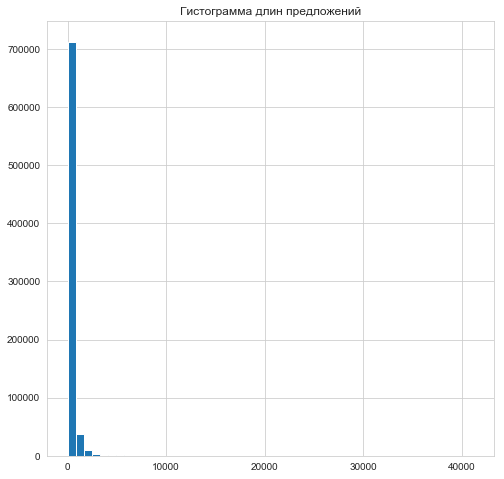

In [44]:
plt.hist([len(s) for s in train_token_ids], bins=50);
plt.title('Гистограмма длин предложений');

In [45]:
###НОМЕР
MAX_SENTENCE_LEN = 1000
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                          
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([ 60134,  14795,     93,     57,   3246,  14795,    203,   1074,   2112,
           843,     32,  14795,     41,     93,   3420,   1357, 235034,     90,
         20791,   1069,   1157,    204,   3442,     75,   6260,   2737,    558,
           845,    843,    195,   7238,  14795,   3204,    905,     75,   1113,
          6018,  13470,  19917,   6145,   1074,   4218,  35916,      3,   1819,
           117,    195,    459,   1082,  60134,      9,    850,  17462,   1185,
        302209,   1231,     39,    331,   1316,  35916,    722,    205,    464,
          2759,   1074,     89,    216,   4764,    195,    375,  44584,    150,
         60134,    904,    764,   2635,  17520,    203,   3730,  48493,  60134,
          1895,   2676,   4335, 189716,    506,    312,   8269,    117,    620,
           345,     89,    117,    195,     13,     18,    850,    459,    724,
           712,  21689,  60134,    542,    660,    145,   1074,    690,   1014,
          1062,   1316,   1993,   2232,

In [46]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [47]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

In [48]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [49]:
 best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=2,
                                            batch_size=20,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 5107.58 сек
Среднее значение функции потерь на обучении 0.6224812670745354
Среднее значение функции потерь на валидации 0.5567517272456806
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 5009.85 сек
Среднее значение функции потерь на обучении 0.5394520977775434
Среднее значение функции потерь на валидации 0.5279720005392847
Новая лучшая модель!



In [205]:
# Сохраним модель
torch.save(trainer.state_dict(), 'sgns.pth')

In [206]:
# Загрузим модель снова
trainer.load_state_dict(torch.load('sgns.pth'))

<All keys matched successfully>

#### Задание 2.2 [5 баллов]

Создайте класс, для удобного обращения с обученными векторами

In [207]:
class Embeddings:
    
    def __init__(self, embedding_dim: int, word2vec_dict: dict):
        """
        embedding_dim: размерность Word2Vec векторов
        word2vec_dict: полученный словарь с эмбеддингами
        """
        self.embedding_dim = embedding_dim
        self.embedding_dim /= (np.linalg.norm(self.embedding_dim, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2vec_dict = word2vec_dict
        self.vec2word_dict = {i: w for w, i in word2vec_dict.items()}
        
    def get_vector(self, word: str) -> np.array:
        """
        word: слово, для которого мы хотим получить эмбеддинг 
        return: вектор слова
        """
        # Ваш код здесь:
        if word not in self.word2vec_dict:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embedding_dim[self.word2vec_dict[word]]
    
    def get_vectors(self, *words):
        word_ids = [self.word2vec_dict[i] for i in words]
        vectors = np.stack([self.embedding_dim[i] for i in word_ids], axis=0)
        return vectors
        
    def get_n_most_similar(self, word: str, top_n_similar: int) -> list:
        """
        word: слово, для которого хотим получить похожие 
        top_n_similar: сколько похожих слов выдать
        return: список таплов (tuple): слово и косинусное расстояние для слова word от текущего слова,
        пример: word = 'спортсмен', return: [("спорт", 0.3), ('чемпион', 0.33), ("атлет", 0.35), ...]
        """
        # Ваш код здесь:
        return self.most_similar_by_vector(self.get_vector(word), top_n_similar=top_n_similar)
    
    def most_similar_by_vector(self, query_vector, top_n_similar: int):
        similarities = (self.embedding_dim * query_vector).sum(-1)
        best_indices = np.argpartition(-similarities, top_n_similar, axis=0)[:top_n_similar]
        result = [(self.vec2word_dict[i], similarities[i]) for i in best_indices]
        result.sort(key=lambda pair: -pair[1])
        return result
        
    def analogy(self, a1: str, a2: str, b1: str, top_n_similar: int) -> list:
        """
        Осуществяет поиск решения уравнения: a1 - a2 + b1 = x
        Пример: для a1='король', a2='мужчина', b1='женщина', ожидается увидеть в ответ x='королева'
        return: список из таплов (tuple), как и в методе get_n_most_similar 
        """
        # Ваш код здесь:
        a1_v = self.get_vector(a1)
        a2_v = self.get_vector(a2)
        b1_v = self.get_vector(b1)
        query = a1_v - a2_v + b1_v
        return self.most_similar_by_vector(query, top_n_similar=top_n_similar)

#### Задание 3.3 [бонус] [3 балла]

Найдите несколько интересных аналогий в словах (что-то типо: король-мужчина+женщина=королева)

In [187]:
import scipy.sparse

In [202]:
!pip install scipy --upgrade

     |████████████████████████████████| 27.7MB 1.0MB/s eta 0:00:01
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0


In [203]:
from scipy import linalg

In [209]:
# Ваш код здесь:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

/Users/anastasiatolstun/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2390: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


In [210]:
# Ваш код здесь:
Embeddings.analogy("религия","отец","сын",10)

TypeError: analogy() missing 1 required positional argument: 'top_n_similar'

#### Задание 3.4 [3 балла]
#### Обучение из коробки

Обучите Word2Vec "из коробки" с помощью библиотеки [gensim](https://radimrehurek.com/gensim/)

In [6]:
!pip install gensim

     |████████████████████████████████| 24.7MB 920kB/s ta 0:00:013
     |████████████████████████████████| 71kB 5.7MB/s eta 0:00:011
     |████████████████████████████████| 133kB 4.1MB/s eta 0:00:01
     |████████████████████████████████| 5.8MB 8.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 5.6MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-1.9.0-cp37-none-any.whl size=72256 sha256=34713b7fd42ef035adfeda5c1536afaf839c7f4f7e88f981f3fdfc188638138b
  Stored in directory: /Users/anastasiatolstun/Library/Caches/pip/wheels/ab/10/93/5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open


In [36]:
# Ваш код здесь:
import gensim

In [37]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [38]:
word2vec.wv.most_similar('религия')

[('христианство', 0.851840078830719),
 ('религиозный', 0.7980008125305176),
 ('протестантизм', 0.7953188419342041),
 ('верование', 0.7946666479110718),
 ('вероучение', 0.78618985414505),
 ('ислам', 0.7825945019721985),
 ('конфессия', 0.7823649644851685),
 ('исповедовать', 0.7777040004730225),
 ('иудаизм', 0.7761166095733643),
 ('атеизм', 0.7745492458343506)]

#### Задание 3.5 [5 баллов]

По смыслу ожидается, что слова относящиеся к одной тематике должны чаще встречаться в одном контексте, а значит и косинусное расстояние между их эмбеддингами должно быть меньше, чем расстояние между произвольной парой слов. Возьмите список из 500-1000 слов, относящихся к каким-нибудь 3-5 тематикам (придумайте сами каким: компьютеры, природа, история, и тд.), снизьте размерность этих слов (их эмбеддингов) с помощью TSNE и изобразите полученные объекты на плоскости. (Ожидается что слова из одной тематики будут образовывать кластеры, которые отдалены от кластеров, относящихся к другой тематике)

In [128]:
from sklearn.manifold import TSNE
# Ваш код здесь:

In [ ]:
nature = Embeddings.most_similar("природа", 500)

In [ ]:
religion = Embeddings.most_similar("религия", 500)

In [ ]:
test_words = pd.concat([nature, religion])
test_vectors = embeddings.get_vectors(*test_words)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Часть 3

### Классификация категории товара

В этом задании Вам предстоит поучастовать в конкурсе от Авито: https://www.kaggle.com/c/texts-classification-ml-hse-2019/leaderboard

Задача конкурса - по заголовку объявления и текстовому описанию классифицировать объявление.

#### Задание 3.0

Загрузите train.csv и test.csv наборы данных

In [135]:
data = pd.read_csv('/Users/anastasiatolstun/Desktop/train 2.csv') # Ваш код здесь
#test = # Ваш код здесь

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
train_source, test_source = np.split(
    np.random.permutation(np.arange(len(data))), [int(np.floor(len(data)*0.7))]
)

In [138]:
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))

Обучающая выборка 2963829
Тестовая выборка 1270213


#### Задание 3.1 [3 балла]

Проведите лемматизацию текстов (для этого Вам может понадобиться пакет pymorphy2: https://pymorphy2.readthedocs.io/en/latest/user/guide.html#id3)

In [12]:
!pip install pymorphy2

In [139]:
import pymorphy2

In [140]:
%time data['title_description'] = data.title + ' ' + data.description

CPU times: user 23.4 s, sys: 1min 43s, total: 2min 7s
Wall time: 4min 17s


In [141]:
data.head()

,title,description,Category_name,Category,title_description
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 ..."
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21,Утюг утп 1000 ватт СССР 1987 год Продам/\n Фот...
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114,Возвму машину с выкупом Возьму машину в аренду...
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27,"Полусапожки полусапожки в отличном состоянии, ..."
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27,Босоножки кожаные Кожаные(натур) босоножки Kar...


In [145]:
from joblib import Parallel, delayed
import multiprocessing
import re
cores = multiprocessing.cpu_count()
morph = pymorphy2.MorphAnalyzer()

In [143]:
def preprocessing(msg):
    msg = re.findall(r'[a-zA-Zа-яА-ЯёЁ]+', msg.lower()) 
    msg = [morph.parse(word)[0].normal_form for word in msg]
    return msg

In [146]:
print(preprocessing(data.title_description[0]))

['эбу', 'renault', 'nissan', 'dci', 'delphi', 'год', 'комплект', 'эбу', 'мозги', 'компьютер', 'мотор', 'двигатель', 'коммутатор', 'электронный', 'блок', 'управление', 'двигатель', 'компьютер', 'мотор', 'для', 'рено', 'kangoo', 'канго', 'канга', 'мегана', 'сценик', 'laguna', 'лагуна', 'clio', 'клио', 'nissan', 'micra', 'ниссан', 'микра', 'и', 'другой', 'рено', 'ниссан', 'дизель', 'с', 'топливный', 'аппаратура', 'делфи', 'б', 'у', 'оригинал', 'отличный', 'состояние', 'проверить', 'с', 'гарантия', 'на', 'весь', 'запчасть', 'предоставляться', 'гарантия', 'возможный', 'установка', 'более', 'подробно', 'в', 'раздел', 'о', 'компания', 'мы', 'дорожить', 'свой', 'репутация', 'и', 'торговать', 'только', 'легальный', 'контрактный', 'запчасть', 'на', 'весь', 'деталь', 'в', 'наличие', 'таможенный', 'документ', 'весь', 'запчасть', 'от', 'автомобиль', 'без', 'пробег', 'по', 'россия', 'отправлять', 'в', 'другой', 'регион', 'таможенный', 'союз', 'транспортный', 'компания', 'или', 'наложный', 'платёж']


## Лемматизация по времени занимает 45 часов на моем компе, код работает, остановила. Аналогично со стоп-словами

In [212]:
data['prep_text'] = Parallel(n_jobs=cores-2)(delayed(preprocessing)(doc) for doc in tqdm_notebook(data.title_description))

KeyboardInterrupt: 

In [16]:
morph.parse('любящие')[0]

Parse(word='любящие', tag=OpencorporaTag('ADJF plur,nomn'), normal_form='любящий', score=0.25, methods_stack=((<DictionaryAnalyzer>, 'любящие', 162, 20),))

#### Задание 3.2 [3 балла]

Удалите "стоп-слова" (предлоги, междометия, ...). Поясните, как именно Вы выбирали стоп-слова

In [148]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=31244 sha256=ba4f2938a945de1d6bc5e7ee9f195af099f4cc708741e4a3c91dc9944b807647
  Stored in directory: /Users/anastasiatolstun/Library/Caches/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [149]:
# Ваш код здесь:
import stop_words

In [150]:
from stop_words import get_stop_words

In [151]:
stops = set(get_stop_words('russian'))

### бесконечно грузится

In [ ]:
for i in stops :
    data['title_description'] = data.preprocessing(data.title_description).replace(to_replace=r'\b%s\b'%i, value="",regex=True)

#### Задание 3.3 [6 баллов]

Осуществите Tf-Idf преобразование текстов

In [ ]:
# Ваш код здесь:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data['prep_text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)

Разбейте данные на обучение и валидацию

In [10]:
# tr_idx - индексы объектов из train, на которых будем обучать модель
# val_idx - индексы объектов из train, на которых будем тестировать обученную модель
np.random.seed(10) # не меняем seed!
tr_idx, val_idx = np.split(
    np.random.permutation(np.arange(len(train_source))), [int(np.floor(len(train_source)*0.7))]
)

Обучите логистическую регрессию на объектах с индексами tr_idx, которую Вы написали в Части 1. В качестве матрицы объект-признак возьмите TfIdf-матрицу, полученную вначале задания 3.3

In [12]:
# Ваш код здесь:
logistic_regression.fit(tr_idx,X)
y_pred=logistic_regression.predict_proba(val_idx)

Посчитайте качество полученной модели на отложенной части (на объектах с индексами val_idx). В качестве метрики возьмите ту, которая используется в конкурсе

In [13]:
# Ваш код здесь:
from sklearn.metrics import accuracy_score
print(accuracy_score(val_idx, y_pred))

#### Задание 3.4 [6 баллов]

Теперь попробуйте обучить логистическую регрессию (из sklearn), но где в качестве признакового описания текста возьмите не матрицу TfIfd, а средневзвешенное Word2Vec описание текста, то есть, для каждого слова из текста вычисляем его Word2Vec эмбеддинг и суммируем эти вектора с некоторыми весами. В качестве весом можно взять значения idf значение слова. Если какого-то слова нет в вашем словаре Word2Vec, то его можно заменить нулевым вектором, или вектором средних из всех Word2Vec векторов.

In [15]:
# Ваш код здесь:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

Посчитайте качество данной модели на отложенной выборке (выборке с индексами val_idx)

In [16]:
# Ваш код здесь:


#### Задание 3.5 [бонус] [10 баллов]

Постарайтесь получить качество на лидерборде выше, чем у baseline решения (0.84726). В данном пункте Вы не ограничены ни моделями, которые можно применять, ни признаками, и даже можно каким-то образом обогащать данные. (Например: можно распрарсить Авито, найти объявления, которые в тесте и взять оттуда истинный класс)

In [17]:
# Ваш код здесь:
